**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets.
0 -> no hate speech
1 -> contains hate speech

**Total Estimated Time = 90 Mins**

In [1]:
# !pip install unidecode
# !pip install word2number
# !pip install contractions
# !python -m spacy download en_core_web_md

### Import Libraries

In [2]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

import re

import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import spacy
import unidecode
import contractions
from word2number import w2n

nlp = spacy.load('en_core_web_md')

### Load Dataset

In [3]:
tweets = pd.read_csv('dataset.csv')
tweets['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

### EDA

- check NaNs

In [4]:
tweets.isna().sum()

id       0
label    0
tweet    0
dtype: int64

- check duplicates

In [5]:
tweets.duplicated().value_counts()

False    31962
dtype: int64

In [6]:
tweets.shape

(31962, 3)

- show samples of data texts to find out required preprocessing steps

In [7]:
tweets['tweet'].head(20)

0      @user when a father is dysfunctional and is s...
1     @user @user thanks for #lyft credit i can't us...
2                                   bihday your majesty
3     #model   i love u take with u all the time in ...
4                factsguide: society now    #motivation
5     [2/2] huge fan fare and big talking before the...
6      @user camping tomorrow @user @user @user @use...
7     the next school year is the year for exams.ð...
8     we won!!! love the land!!! #allin #cavs #champ...
9      @user @user welcome here !  i'm   it's so #gr...
10     â #ireland consumer price index (mom) climb...
11    we are so selfish. #orlando #standwithorlando ...
12    i get to see my daddy today!!   #80days #getti...
13    @user #cnn calls #michigan middle school 'buil...
14    no comment!  in #australia   #opkillingbay #se...
15    ouch...junior is angryð#got7 #junior #yugyo...
16    i am thankful for having a paner. #thankful #p...
17                               retweet if you 

In [8]:
tweets['label'].unique()

array([0, 1], dtype=int64)

- check dataset balancing

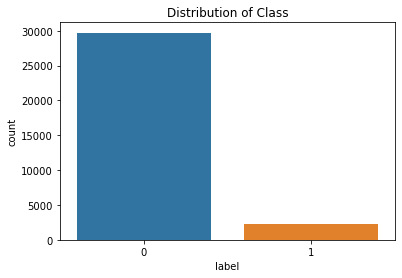

In [9]:
sns.countplot(tweets['label']).set_title('Distribution of Class');

In [10]:
tweets.head(15)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


### Split the data

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(tweets['tweet'],tweets['label'],
                                                   test_size=0.2, random_state=42,
                                                   stratify=tweets['label'])
print(len(X_train))
print(len(X_test))
type(X_train)

25569
6393


pandas.core.series.Series

In [12]:
isinstance(X_train, pd.DataFrame)

False

- Cleaning and Preprocessing are:
    - 1 Remove the @ and #
    - 2 
    - 3

### Cleaning and Preprocessing

In [13]:
# pattern = re.compile(r'[\@|\#]\w+ | ^\s+ | \W | \w\!+')
# tweets['clean_tweets'] = tweets['tweet'].replace(pattern,'')

def process_tweet(tweet):
    return " ".join(re.sub("([\@][A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [14]:
#tweets['clean_tweets'] = tweets['tweet'].apply(process_tweet)

In [15]:
#tweets['tweets'].head(50)

In [16]:
tweets.head(15)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [17]:
# X_train = X_train.apply(process_tweet)
# X_train

In [18]:
def process_tweet(tweet):
    return " ".join(re.sub("([\@][A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())
 
def text_preprocessing(text):
    text = process_tweet(text)

    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
 
    text = text.strip()
    text =  " ".join(text.split())
 
    text = unidecode.unidecode(text)
 
    text = contractions.fix(text)
 
    text = text.lower()
 
    doc = nlp(text) 
    clean_text = []

    for token in doc:
        flag = True
        edit = token.text

        if token.is_stop and token.pos_ != 'NUM': 
            flag = False
#         if token.pos_ == 'PUNCT' and flag == True: 
#             flag = False
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        if (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        if token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        elif token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [19]:
X_train = X_train.apply(lambda x : " ".join(text_preprocessing(x)))

In [20]:
X_train

26247           order black amp sexy s collection cantwait
13681               s s m tell andrew jackson cantankerous
25676                   video hateful liberal america crap
14544    monaco podium time guy maybe mclarenhonda cana...
25411    wow open amateur hour fox golf people walk com...
                               ...                        
15438    scratch tweet jo sorry borrow box tell complement
29797                   special moment family familia ness
15613                          kudo compliant itaxnirahisi
1955     streetautopia attack bull game 3d think head c...
9371                                                    pm
Name: tweet, Length: 25569, dtype: object

In [21]:
# def stemmeing(text):
#     stemmed_words = [stemmer.stem(word) for word in text]
#     return " ".join(re.sub("([\@|\#][A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [22]:
X_test = X_test.apply(lambda x : " ".join(text_preprocessing(x)))

**If it takes 60 Mins till here, you are doing Great** <br>
**If not! You also are doing Great**

In [23]:
tweets['tweet'] = tweets['tweet'].apply(lambda x : " ".join(text_preprocessing(x)))

### Modelling

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

vec = CountVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit(X_train, y_train);

#### Evaluation

In [25]:
from sklearn import metrics

def print_report(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.86      0.54      0.67       448

    accuracy                           0.96      6393
   macro avg       0.91      0.77      0.82      6393
weighted avg       0.96      0.96      0.96      6393

accuracy: 0.962


### Enhancement

- Using different N-grams
- Using different text representation technique

In [26]:
# vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), min_df=.01, max_df=.3)
# clf = LinearSVC()
# pipe_tfidf = make_pipeline(vec, clf)
# pipe_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.3, min_df=0.01,
                                 ngram_range=(3, 5))),
                ('linearsvc', LinearSVC())])

In [27]:
# print_report(pipe_tfidf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5945
           1       0.79      0.49      0.61       448

    accuracy                           0.96      6393
   macro avg       0.88      0.74      0.79      6393
weighted avg       0.95      0.96      0.95      6393

accuracy: 0.955


In [28]:
from tqdm import tqdm

In [29]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

In [30]:
longest_input = get_longest_text(tweets['tweet'])
longest_input

37

In [31]:
import numpy as np
data_emb = np.zeros((len(tweets['tweet']), longest_input, 300))

for i, text in enumerate(tqdm(nlp.pipe(tweets['tweet']), total=len(tweets['tweet']))):
#     print(text)
#     print(type(text))
    for j, token in enumerate(text):
        #         print(token)
#         print(type(token))
        data_emb[i, j] = token.vector
#     break

100%|██████████████████████████████████████████████████████████████████████████| 31962/31962 [00:29<00:00, 1100.09it/s]


In [32]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((longest_input, 300))
reshaped = tf.keras.layers.Reshape((longest_input, 300, 1))(inputs)


filters = [2, 3, 4]

# define the conv net
conv_1 = tf.keras.layers.Conv2D(100, (filters[0], 300), activation='relu')(reshaped)
conv_2 = tf.keras.layers.Conv2D(100, (filters[1], 300), activation='relu')(reshaped)
conv_3 = tf.keras.layers.Conv2D(100, (filters[2], 300), activation='relu')(reshaped)

# define max-pooling
pool_1 = tf.keras.layers.MaxPooling2D((longest_input - filters[0] + 1, 1), strides=(1,1))(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((longest_input - filters[1] + 1, 1), strides=(1,1))(conv_2)
pool_3 = tf.keras.layers.MaxPooling2D((longest_input - filters[2] + 1, 1), strides=(1,1))(conv_3)

# concatenate the convs
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(merged_tensor)

# add a dense layer
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(1, activation='sigmoid')(clf)

In [33]:
# compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 37, 300)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 37, 300, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 36, 1, 100)   60100       ['reshape[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 35, 1, 100)   90100       ['reshape[0][0]']                
                                                                                              

In [34]:
inputs.shape

TensorShape([None, 37, 300])

In [36]:
# !pip install pydot --user
# !pip install graphviz --user

In [37]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [38]:
# let's split the data and train our model
X_train,X_test, y_train, y_test = train_test_split(data_emb,tweets['label'],
                                                   test_size=0.2, random_state=42)

In [39]:
# X_train

array([[[-0.70077997,  0.12019   ,  0.063648  , ..., -0.52301002,
         -0.81168002,  0.15805   ],
        [-0.74085999,  0.096661  , -0.12616   , ..., -0.012397  ,
          0.39416999, -0.029652  ],
        [-0.62774003,  0.39978001, -0.47624001, ..., -0.10292   ,
          0.083312  ,  0.13992   ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.84258002, -0.26696   ,  0.68818003, ...,  0.42965999,
         -0.27226999,  0.041207  ],
        [-0.73922998, -0.030888  ,  0.2376    , ...,  0.12554   ,
          0.0076992 , -0.080382  ],
        [-0.76533002,  0.16752   , -0.15765999, ...,  0.10278   ,
         -0.77441001, -0.070121  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [41]:
model.fit(X_train,  y_train,epochs = 10)

Epoch 1/10
800/800 [==============================] - 9s 12ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 2/10
800/800 [==============================] - 10s 12ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 3/10
800/800 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 5/10
800/800 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 6/10
800/800 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 7/10
800/800 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 9/10
800/800 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.9301
Epoch 10/10
800/800 [==============================] - 10s 12ms/step - loss: 0.0000e+00 - acc: 0.9

In [42]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - acc: 0.9287


[0.0, 0.9286719560623169]

#### Done!